# Forecasting Simple Time-Series

This example shows how to estimate time-series that are relatively constant or have a defined trend, but other than that do not have any patterns over time. If there are other patterns in the data, such as seasonality, see Forecasting Complex Time-Series.

## Load in the Data

We'll load in the data with `pandas`, which should be review.

In [1]:
import pandas as pd
df = pd.read_excel('Sales COGS for Lab.xlsx')

In [2]:
df.head()

,Unnamed: 0,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00
0,Sales,4500,5200,6100
1,Cost of Goods Sold,1200,1700,1900


Here we should use Sales, Cost of Goods sold as the index. Load in by setting the index column.

In [3]:
df = pd.read_excel('Sales COGS for Lab.xlsx', index_col=0)
df.head()

,2017-12-31,2018-12-31,2019-12-31
Sales,4500,5200,6100
Cost of Goods Sold,1200,1700,1900


Now that looks better.

## Plot Data

For an effective plot, we will need to transpose the data, so that the dates are the index (x-axis on plot), and the data types are columns (series on plot). Thankfully this is as simple as `df.T`.

In [4]:
df.T

,Sales,Cost of Goods Sold
2017-12-31,4500,1200
2018-12-31,5200,1700
2019-12-31,6100,1900


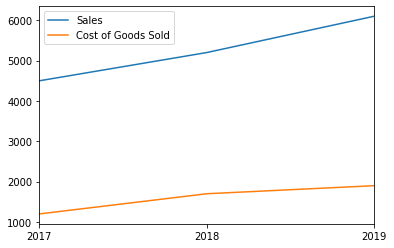

In [5]:
%matplotlib inline

df.T.plot.line()

## Forecast Using Most Recent Value

This is the simplest forecast, just keep it the same as it was. 

Right now we have the dates as the columns. So access the columns and take the max to find the latest date.

In [6]:
last_date = df.columns.max()
last_date

Timestamp('2019-12-31 00:00:00')

Now select the values which have the latest date as the forecast

In [7]:
fcst_sales = df.loc['Sales'][last_date]
fcst_cogs = df.loc['Cost of Goods Sold'][last_date]
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $6,100 and for COGS is $1,900


## Forecast Using Average

We have already seen how to take averages of `pandas` `Series`:

In [8]:
fcst_sales = df.loc['Sales'].mean()
fcst_cogs = df.loc['Cost of Goods Sold'].mean()
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $5,267 and for COGS is $1,600


## Forecast Using Trend

There are two methods to forecast using the trend.

### Trend Method 1: By Regression

We will estimate the following regression model:
$$y_t = a + \beta t + \epsilon_t$$

#### Create DataFrame with $t$

First we need to create a `DataFrame` which has a column for the $y$ and a column for the $t$:.

To do this, first we can create a `DataFrame` from the `Series` we want to forecast.

In [9]:
for_fcst_df = pd.DataFrame(df.loc['Sales'])
for_fcst_df

,Sales
2017-12-31,4500
2018-12-31,5200
2019-12-31,6100


We can use `reset_index(drop=True)` to get rid of the date index.

In [10]:
for_fcst_df = for_fcst_df.reset_index(drop=True)
for_fcst_df

,Sales
0,4500
1,5200
2,6100


We can now use `reset_index()` without the `drop=True` to get this new 0, 1, 2 index as a column.

In [11]:
for_fcst_df = for_fcst_df.reset_index()
for_fcst_df

,index,Sales
0,0,4500
1,1,5200
2,2,6100


We can also rename that column.

In [12]:
for_fcst_df = for_fcst_df.rename(columns={'index': 't'})
for_fcst_df

,t,Sales
0,0,4500
1,1,5200
2,2,6100


Let's wrap this all up in a function as we'll need to use this for COGS as well, and for the CAGR approaches.

In [13]:
def for_forecast_df_from_orig_df(orig_df, series_name):
    """
    From a DataFrame where index is name of series to be forecasted and columns are time periods, create a 
    DataFrame with two columns, t in periods and the value to be forecasted, and rows are time periods.
    """
    for_fcst_df = pd.DataFrame(orig_df.loc[series_name])
    for_fcst_df = for_fcst_df.reset_index(drop=True).reset_index()
    for_fcst_df = for_fcst_df.rename(columns={'index': 't'})
    return for_fcst_df

for_forecast_df_from_orig_df(df, 'Cost of Goods Sold')

,t,Cost of Goods Sold
0,0,1200
1,1,1700
2,2,1900


#### Now Run Regression

This should be review from the cost of equity exercise.

In [14]:
import statsmodels.api as sm

model = sm.OLS(for_fcst_df['Sales'], sm.add_constant(for_fcst_df['t']), hasconst=True)
results = model.fit()
results.summary()

c:\users\admin\.virtualenvs\fin-model-course-gvj3lsuv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\admin\.virtualenvs\fin-model-course-gvj3lsuv\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     192.0
Date:                Tue, 19 Nov 2019   Prob (F-statistic):             0.0459
Time:                        13:28:25   Log-Likelihood:                -15.816
No. Observations:                   3   AIC:                             35.63
Df Residuals:                       1   BIC:                             33.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4466.6667     74.536     59.927      0.011    3519.602    5413.731
t            800.0000     57.735     13.856      0.046      66.407    1533.593
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         2.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now get the intercept and $\beta$ from the regression results.

In [15]:
intercept = results.params['const']
beta = results.params['t']

In [16]:
intercept

4466.666666666667

In [17]:
beta

799.9999999999992

#### Now Predict from Regression Results

In [18]:
fcst_sales = intercept + beta * 3
fcst_sales

6866.666666666664

Now let's wrap up the regression approach into a function to use it with COGS as well.

In [19]:
def intercept_and_t_beta_from_for_forecast_df(for_fcst_df, series_name):
    """
    Calculates intercept and beta of time periods from DataFrame set up for forecasting
    """
    model = sm.OLS(for_fcst_df[series_name], sm.add_constant(for_fcst_df['t']), hasconst=True)
    results = model.fit()
    intercept = results.params['const']
    beta = results.params['t']
    return intercept, beta

def predict_from_intercept_beta_and_t(intercept, beta, t):
    """
    Predicts value in period t based off regression intercept and beta
    """
    return intercept + beta * t

intercept, beta = intercept_and_t_beta_from_for_forecast_df(for_fcst_df, 'Sales')
fcst_sales = predict_from_intercept_beta_and_t(intercept, beta, 3)
fcst_sales

6866.666666666664

#### Entire Approach for COGS Using Functions

Let's write one more function to do the entire forecast, putting everything together.

In [20]:
def forecast_trend_reg(df, series_name, t):
    """
    Full workflow of forecasting trend via regression
    """
    for_fcst_df = for_forecast_df_from_orig_df(df, series_name)
    intercept, beta = intercept_and_t_beta_from_for_forecast_df(for_fcst_df, series_name)
    fcst = predict_from_intercept_beta_and_t(intercept, beta, t)
    return fcst

fcst_sales = forecast_trend_reg(df, 'Sales', 3)
fcst_cogs = forecast_trend_reg(df, 'Cost of Goods Sold', 3)
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $6,867 and for COGS is $2,300


### Trend Method 2: By CAGR

Let's work off the `DataFrame` set up for forecasting from the regression approach.

In [21]:
for_fcst_df = for_forecast_df_from_orig_df(df, 'Sales')
for_fcst_df

,t,Sales
0,0,4500
1,1,5200
2,2,6100


We want to calculate $$\frac{y_T}{y_0}^{\frac{1}{n}} - 1$$

We can use `.iloc` (integer location) to get the first and last values of sales.

In [22]:
y_0 = for_fcst_df['Sales'].iloc[0]
y_0

4500

In [23]:
y_T = for_fcst_df['Sales'].iloc[-1]
y_T

6100

We can get the number of time periods elapsed in a similar way.

In [24]:
n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
n

2

Now just calculate

In [25]:
cagr = (y_T / y_0)**(1 / n) - 1
cagr

0.16428327977153212

Now to get the predicted value for period 3

Let's wrap this up into functions.

In [26]:
def cagr_from_for_forecast_df(for_fcst_df, series_name):
    """
    Calculates CAGR from DataFrame set up for forecasting
    """
    y_0 = for_fcst_df[series_name].iloc[0]
    y_T = for_fcst_df[series_name].iloc[-1]
    n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
    cagr = (y_T / y_0)**(1 / n) - 1
    return cagr


def predict_from_for_forecast_df_and_cagr(for_fcst_df, series_name, cagr, t):
    """
    Forecast value from DataFrame set up for forecasting and calculated CAGR
    """
    y_T = for_fcst_df[series_name].iloc[-1]
    n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
    
    future_nper = t - n
    fcst = y_T * (1 + cagr)**future_nper
    return fcst


cagr = cagr_from_for_forecast_df(for_fcst_df, 'Sales')
fcst_sales = predict_from_for_forecast_df_and_cagr(for_fcst_df, 'Sales', cagr, 3)
fcst_sales

7102.1280066063455

Now let's put the entire approach in one function.

In [27]:
def forecast_trend_cagr(df, series_name, t):
    """
    Full workflow of forecasting trend via CAGR
    """
    for_fcst_df = for_forecast_df_from_orig_df(df, series_name)
    cagr = cagr_from_for_forecast_df(for_fcst_df, series_name)
    fcst = predict_from_for_forecast_df_and_cagr(for_fcst_df, series_name, cagr, t)
    return fcst

fcst_sales = forecast_trend_cagr(df, 'Sales', 3)
fcst_cogs = forecast_trend_cagr(df, 'Cost of Goods Sold', 3)
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $7,102 and for COGS is $2,391


## Forecasting as a %

We can estimate COGS as a percentage of sales. To do this, we must first forecast sales, then forecast the percentage of sales, then combine the two. We already have a sales forecast from the last section, so let's keep that. Next is forecasting the percentage of sales. To do this we must first calculate the historical percentage of sales.

In [28]:
df.loc['COGS % Sales'] = df.loc['Cost of Goods Sold'] / df.loc['Sales']
df

,2017-12-31,2018-12-31,2019-12-31
Sales,4500.000000,5200.000000,6100.000000
Cost of Goods Sold,1200.000000,1700.000000,1900.000000
COGS % Sales,0.266667,0.326923,0.311475


Now we can forecast this by any of the available methods.

In [29]:
fcst_cogs_pct_sales = forecast_trend_reg(df, 'COGS % Sales', 3)
fcst_cogs_pct_sales

0.3464971276446685

Now combine with the existing sales forecast.

In [30]:
fcst_cogs = fcst_sales * fcst_cogs_pct_sales
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $7,102 and for COGS is $2,461


## All the Approaches, Together

There is a dizzying array of forecast options, even only considering simple forecast methods. Here is a quick overview of the approaches.

In [31]:
def forecast_by_method(df, series_name, method, t):
    if method == 'average':
        return df.loc[series_name].mean()
    elif method == 'recent':
        last_date = df.columns.max()
        return df.loc[series_name][last_date]
    elif method == 'trend reg':
        return forecast_trend_reg(df, series_name, t)
    elif method == 'trend cagr':
        return forecast_trend_cagr(df, series_name, t)

methods = [
    'average',
    'recent',
    'trend reg',
    'trend cagr'
]

t = 3

cogs_forecasts = []
for sales_method in methods:
    fcst_sales = forecast_by_method(df, 'Sales', sales_method, t)
    for cogs_method in methods:
        # Handle levels for COGS
        fcst_cogs = forecast_by_method(df, 'Cost of Goods Sold', cogs_method, t)
        cogs_forecasts.append(fcst_cogs)
        print(f'The forecasted value for sales ({sales_method}) is ${fcst_sales:,.0f} and for COGS ({cogs_method}) is ${fcst_cogs:,.0f}')
        # Handle % of sales for COGS
        fcst_cogs_pct = forecast_by_method(df, 'COGS % Sales', cogs_method, t)
        fcst_cogs = fcst_cogs_pct * fcst_sales
        cogs_forecasts.append(fcst_cogs)
        print(f'The forecasted value for sales ({sales_method}) is ${fcst_sales:,.0f} and for COGS (% of Sales, {cogs_method}) is ${fcst_cogs:,.0f}')

The forecasted value for sales (average) is $5,267 and for COGS (average) is $1,600
The forecasted value for sales (average) is $5,267 and for COGS (% of Sales, average) is $1,589
The forecasted value for sales (average) is $5,267 and for COGS (recent) is $1,900
The forecasted value for sales (average) is $5,267 and for COGS (% of Sales, recent) is $1,640
The forecasted value for sales (average) is $5,267 and for COGS (trend reg) is $2,300
The forecasted value for sales (average) is $5,267 and for COGS (% of Sales, trend reg) is $1,825
The forecasted value for sales (average) is $5,267 and for COGS (trend cagr) is $2,391
The forecasted value for sales (average) is $5,267 and for COGS (% of Sales, trend cagr) is $1,773
The forecasted value for sales (recent) is $6,100 and for COGS (average) is $1,600
The forecasted value for sales (recent) is $6,100 and for COGS (% of Sales, average) is $1,840
The forecasted value for sales (recent) is $6,100 and for COGS (recent) is $1,900
The forecast

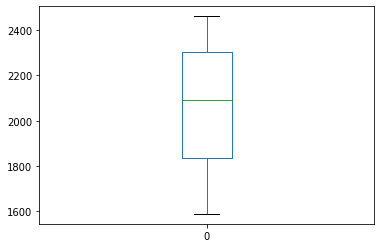

In [32]:
pd.DataFrame(cogs_forecasts).plot.box()